In [2]:
# ! pip3 install pandas pillow wordcloud matplotlib numpy
import pandas as pd
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
import numpy as np
import math


In [ ]:
# Load the games data into a Pandas dataframe
N = 4000

### Processing step 1
Since our dataset is very large and sorted by Metacritic rating, we'll randomly sample 4000 rows to get a more balanced set.

In [ ]:
# Load the data into a Pandas dataframe
def load_data(file):
  return pd.read_csv(file)

# Create a sample from a file
def create_sample(n=N, file='all_games.csv', entire=False):
    df = pd.read_csv(file)
    if entire or n == -1:
        return df
    sample = df.sample(n)
    print("length of sample: ",len(sample))
    return sample

### Processing step 2
Here, we'll filter out any duplicate entries. Since we've got the same game on multiple platforms, we'll only keep the highest rated version. To do this, we'll sort the dataset by Metacritic rating and then drop any duplicate entries based on the game's name.

In [ ]:
def filter_duplicates(sample):
    # Sort the games by their 'meta_score' column in descending order
    sample = sample.sort_values(by='meta_score', ascending=False)

    # Drop any duplicate games from the sample, keeping only the highest rated
    # version of each game.
    sample = sample.drop_duplicates(subset=['name'], keep='first')
    print("length of sample after removing duplicates: ",len(sample))
    return sample

### Processing step 3
Since some of the entries have empty reviews and there aren't enough of the same game to fill in the missing data, we'll remove the rows with empty reviews.

In [ ]:
#remove rows where user_review = 'tbd'
def remove_empty_reviews(sample):
    sample = sample[sample.user_review != 'tbd']
    print("length of sample after removing empty reviews",len(sample))
    return sample

### Processing step 4
Strip whitespace + non-ASCII chars from `summary`, `user_review` columns. This is to clean the data for steps that depend upon the content of the string data.

In [ ]:
def clean_summaries(sample):
    # remove all whitespace and then just keep ascii chars
    sample['summary'] = sample['summary'].astype(str).apply(lambda x: x.strip().encode("ascii", errors="ignore").decode("ascii"))
    return sample

### Processing step 5
Normalize Rating of the given columns. This is a measure of how far away from the mean a value is in context of the spread of the data.

In [ ]:
def normalize_rating(sample, columns):
    for column in columns:
      new_col = column + "_normalized"
      mean = sample.loc[:, column].astype(float).mean()
      std = sample.loc[:, column].astype(float).std()

      # create a new column based on the values of the mean, std
      sample[new_col] = sample[column].astype(float).apply(lambda x: (x-mean)/std)

    return sample

### Processing step 6

Filter release date column to be in mm-dd-yyyy format. This is because the format is of differently written strings, and it's important to standardize it to a more robust data type.

In [ ]:
def format_date(sample):
    # turn input to datatime object
    sample['release_date'] = pd.to_datetime(sample['release_date'], format='%B %d, %Y')
    return sample

format_date(create_sample())

length of sample:  4000


,index,name,platform,release_date,summary,meta_score,user_review
18600,18600,Power Gig: Rise of the SixString,Xbox 360,2010-10-19,Power Gig: Rise of the SixString will transpor...,36,2.1
6510,6510,La-Mulana EX,PlayStation Vita,2015-03-03,Will you fall victim to deadly traps or unrave...,77,7.8
15868,15868,Spider-Man: Friend or Foe,Wii,2007-10-02,Spider-Man: Friend or Foe challenges players t...,59,8.3
7365,7365,Area 51,PlayStation 2,2005-04-25,"Featuring online play, Area 51 is set in the U...",75,8.3
1303,1303,Saints Row IV,PC,2013-08-19,Saints Row IV is an open world game that conti...,86,7.4
...,...,...,...,...,...,...,...
1722,1722,Tony Hawk's Underground,Xbox,2003-10-27,Get ready for a major new step for the Tony Ha...,85,8.4
11910,11910,Heroki,Switch,2018-07-20,The peaceful sky village of Levantia is in dan...,68,7.1
5771,5771,Greed Corp,PlayStation 3,2010-02-25,[Playstation Network] Why share when you can h...,78,7.7
13713,13713,Tao Feng: Fist of the Lotus,Xbox,2003-03-18,"Clothes will tear, blood will spill, and bones...",65,6.0


###Processing step 7

Split 1 Column into different parts of the column's information, Since we will need the different components of the release dates for different purposes.

In [ ]:
def year_and_month(sample):
    # extrapolate features into own columns
    sample['year'] = sample['release_date'].dt.year
    sample['month'] = sample['release_date'].dt.strftime('%B')
    return sample

### Processing step 8
Drop an irrelevant Column like index. The dataframe is internally indexed and also indexable by us, so we don't require external id.

In [ ]:
# takes a sample and column name to drop
def drop_column(sample, col="index"):
    sample = sample.drop(col, axis=1)
    return sample

### Processing step 9
Supplement the data in the dataframe to have data from another dataset. Here, our original dataset didn't have genre information, so we have to add that information from another database that we scraped from https://api-docs.igdb.com/

In [ ]:
def add_genres(sample, file):
    names = {}
    # read the other file
    extra = create_sample(-1, file)

    # create a word map of genres and basic names
    for key, i in enumerate(extra["name"]):
        second = extra.at[key, "Genre"]
        names["".join([l.lower() for l in i if l.isalnum()])] = second

    # check for names from the dictionary and supplement genres
    for key, i in enumerate(sample["name"]):
        cleaned = "".join([l.lower() for l in i if l.isalnum()])
        sample.at[key, "genre"] = None
        if cleaned in names:
            sample.at[key, "genre"] = names[cleaned]

    print(len(sample[['genre']]))
    return sample

s1 = create_sample()
add_genres(s1, "games.csv")

length of sample:  4000
7149


,index,name,platform,release_date,summary,meta_score,user_review,genre
17497,17497.0,Afterfall: InSanity,PSP,"November 25, 2011",Year 2035 Almost 20 years ago the citizens of ...,50.0,5.9,NaN
16379,16379.0,Rocketmen: Axis of Evil,PlayStation 3,"March 6, 2008","[Downloadable Game] In this arcade shooter, pl...",57.0,5.3,NaN
16535,16535.0,EA Replay,PC,"November 14, 2006",EA Replay Title List: B.O.B. - Help B.O.B. bla...,56.0,tbd,NaN
17051,17051.0,Belief & Betrayal,PC,"March 25, 2008","As journalist Jonathan Danter, you discover th...",53.0,4.5,NaN
1274,1274.0,Astebreed,PC,"May 30, 2014",Climb into the pilot's seat of an otherworldly...,86.0,7.4,None
...,...,...,...,...,...,...,...,...
3993,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None
3994,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None
3995,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None
3997,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Fighting


### Processing step 10

Remove award text from summary column. For example, some rows look like `"[Metacritic's 2007 Wii Game of the Year] The ultimate Nintendo..."`. Since not enough rows have award info, there is not point in extracting it as its own feature.

In [ ]:
def remove_award_text(sample):
    # match prefix w regex
    sample['summary'] = sample['summary'].str.replace(r'\[.*\] ', '', regex=True)
    return sample

## Exploratory Data Analysis - EDA
# 1: Basic Statistics
Some basic statistics such as mean, median, mode, standard deviation, variance, and range to summarize the distribution of ratings in the dataset.

In [ ]:
def return_basic_stats(sample, cols):
  stats = {}

  # for each metric
  for col in cols:
    # convert to float
    frame = sample[col].astype(float)

    # use std pandas functions for stats
    mean = frame.mean()
    mode = frame.mode()
    median = frame.median()
    std = frame.std()
    rnge = [frame.min(), frame.max()]
    variance = frame.var()

    # bind all together to return
    stats[col] = {
        "mean":mean,
        "mode":mode,
        "median":median,
        "std. deviation": std,
        "range": rnge,
        "variance": variance,
    }

  return stats

sample = create_sample(-1)
sample = remove_empty_reviews(sample)
stats = return_basic_stats(sample, ["user_review", "meta_score"])
print(stats)

length of sample after removing empty reviews 17435
{'user_review': {'mean': 6.9908459994264405, 'mode': 0    7.7
Name: user_review, dtype: float64, 'median': 7.3, 'std. deviation': 1.35155404971064, 'range': [0.2, 9.7], 'variance': 1.8266983492892312}, 'meta_score': {'mean': 71.19965586464009, 'mode': 0    80.0
Name: meta_score, dtype: float64, 'median': 73.0, 'std. deviation': 12.210737046864509, 'range': [20.0, 99.0], 'variance': 149.10209922766938}}


# 2: Data Cleaning
Handled missing values, duplicate values, and inconsistencies in the dataset. See the entire section above EDA for data cleaning.

In [ ]:
def clean_data(sample):
  # call all the defined functions from the data cleaning section in the correct order
  sample = add_genres(sample, "games.csv")
  sample = filter_duplicates(sample)
  sample = remove_empty_reviews(sample)
  sample = normalize_rating(sample, ["user_review", "meta_score"])
  sample = format_date(sample)
  sample = year_and_month(sample)
  sample = drop_column(sample, "index")
  sample = remove_award_text(sample)
  sample = clean_summaries(sample)
  return sample

sample = create_sample(-1)
sample = clean_data(sample)

18800
length of sample after removing duplicates:  12254
length of sample after removing empty reviews 11262


# 3: Data Visualization
See how many games occur each year grouped by genres. This way we can see how our data looks all laid out. A heatmap here relates to 3d data of the 3d variables described above.

18800
length of sample after removing duplicates:  12254
length of sample after removing empty reviews 11262


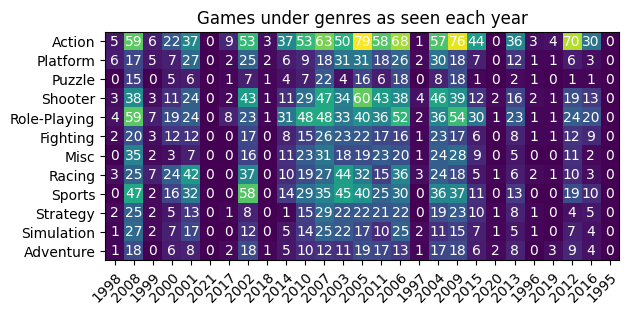

In [ ]:
def group_genres_years(sample):
  data = {}

  # create a map of how many genres of games are found each year
  for i, row in sample.iterrows():
    if row["year"] in data:
      if row["genre"] != None and row["genre"] in data[row["year"]]:
        data[row["year"]][row["genre"]] += 1
      else:
        data[row["year"]][row["genre"]] = 1
    else:
      data[row["year"]] = {}
      data[row["year"]][row["genre"]] = 1

  return data

def create_heat_map(data):
  big = {}
  years = data.keys()
  genre_data = {}
  for k, i in data.items():
    if len(i) > len(big):
      big = i

  # create right shaped data to plot from the input
  for i, year_data in data.items():
    for genre in big.keys():
      if genre not in year_data:
        if genre not in genre_data:
          genre_data[genre] = [0]
          continue
        genre_data[genre].append(0)
      else:
        if genre not in genre_data:
          genre_data[genre] = [year_data[genre]]
          continue

        genre_data[genre].append(year_data[genre])

  data = [v for i,v in genre_data.items() if i !=None]
  fig, ax = plt.subplots()
  im = ax.imshow(data)

  # adapted from https://matplotlib.org/
  # Show all ticks and label them with the respective list entries
  ax.set_xticks(np.arange(len(years)), labels=years)
  ax.set_yticks(np.arange(len(big)-1), labels=[i for i, x in big.items() if i !=None])

  # Rotate the tick labels and set their alignment.
  plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
          rotation_mode="anchor")

  # Loop over data dimensions and create text annotations.
  for i in range(len(data)):
      for j in range(len(years)):
          # print(i,j)
          text = ax.text(j, i, data[i][j],
                        ha="center", va="center", color="w")

  ax.set_title("Games under genres as seen each year")
  fig.tight_layout()
  plt.show()


data = group_genres_years(clean_data(create_sample(-1)))
create_heat_map(data)



# 4: Dimensionality Reduction
Drop the Platform column since that is not ultimately used in the problem statement solution.

In [ ]:
# can potentially provide function w a list of dimensions to drop through dims
def reduce_dimension(sample, dims):
  for dim in dims:
    sample = drop_column(sample, dim)
  return sample

data = clean_data(create_sample(-1))
reduce_dimension(data, ["platform"])


18800
length of sample after removing duplicates:  12254
length of sample after removing empty reviews 11262


,name,release_date,summary,meta_score,user_review,genre,user_review_normalized,meta_score_normalized,year,month
0,The Legend of Zelda: Ocarina of Time,1998-11-23,"As a young boy, Link is tricked by Ganondorf, ...",99,9.1,Action,1.521414,2.223420,1998,November
2,Grand Theft Auto IV,2008-04-29,What does the American Dream mean today? For N...,98,7.7,Action,0.471825,2.143015,2008,April
3,SoulCalibur,1999-09-08,"This is a tale of souls and swords, transcendi...",98,8.4,Fighting,0.996619,2.143015,1999,September
1,Tony Hawk's Pro Skater 2,2000-09-20,As most major publishers' development efforts ...,98,7.4,Sports,0.246913,2.143015,2000,September
14,Tony Hawk's Pro Skater 3,2001-10-28,Challenge up to four friends in online competi...,97,7.5,Sports,0.321884,2.062609,2001,October
...,...,...,...,...,...,...,...,...,...,...
18793,Charlie's Angels,2003-07-09,"Join Natalie, Dylan, and Alex for an intense a...",23,4.3,Action,-2.077176,-3.887407,2003,July
18795,Fast & Furious: Showdown,2013-05-21,Fast & Furious: Showdown takes some of the fra...,22,1.3,Action,-4.326295,-3.967813,2013,May
18796,Drake of the 99 Dragons,2003-11-03,Drake is out for revenge in a supernatural Hon...,22,1.7,Shooter,-4.026412,-3.967813,2003,November
18797,Afro Samurai 2: Revenge of Kuma Volume One,2015-09-22,"Head out on a journey of redemption, driven by...",21,2.9,None,-3.126765,-4.048218,2015,September


# 5: Feature Engineering
Add a summary sentinent and average rating `(user_rating+meta_score)/2` column to the sample. We are engineering this feature based on previously given data because we will want to use a baseline average score that represents both critics and users.

In [ ]:
def engineer_features(sample):
  # initialize col to 0
  sample["avg_score"] = 0
  for i, r in sample.iterrows():
    # average both critic and user score
    sample.at[i,"avg_score"] = (float(r["user_review"])*10+float(r["meta_score"]))/2
  return sample

# 6: K-max and k-min Detection
Find k-top and least rated games from the dataset. We will use this to see how it would differ by critics, users, and their average score.

In [ ]:
K = 3
def print_k_min_max(sample, k=K, col="meta_score"):
  # use the inbuilt nlargest and nsmallest method
  print("\n")
  sample[col] = pd.to_numeric(sample[col])
  print("Top",k, "games with the highest", col, ":")
  # just print the names
  print(sample.nlargest(k,[col])["name"])

  print("\n")
  print("Top",k, "games with the lowest", col, ":\n")
  print(sample.nsmallest(k,[col])["name"])
  print("------ *** ------\n")

sample = clean_data(create_sample(-1))
sample = engineer_features(sample)
print_k_min_max(sample)
print_k_min_max(sample, col="user_review")
print_k_min_max(sample, col="avg_score")


18800
length of sample after removing duplicates:  12254
length of sample after removing empty reviews 11262


Top 3 games with the highest meta_score :
0    The Legend of Zelda: Ocarina of Time
2                     Grand Theft Auto IV
3                             SoulCalibur
Name: name, dtype: object


Top 3 games with the lowest meta_score :

18798     Infestation: Survivor Stories (The War Z)
18797    Afro Samurai 2: Revenge of Kuma Volume One
18795                      Fast & Furious: Showdown
Name: name, dtype: object
------ *** ------



Top 3 games with the highest user_review :
2450                 Ghost Trick: Phantom Detective
3504    Z.H.P. Unlosing Ranger vs Darkdeath Evilman
4844                                   GrimGrimoire
Name: name, dtype: object


Top 3 games with the lowest user_review :

11261             Madden NFL 21
10858             Madden NFL 22
15693    Warcraft III: Reforged
Name: name, dtype: object
------ *** ------



Top 3 games with the highest avg_sc

# 7: Distribution Analysis
Plot the data from the `user_rating`and `meta_rating`columns to understand how rating values are distributed.

18800
length of sample after removing duplicates:  12254
length of sample after removing empty reviews 11262


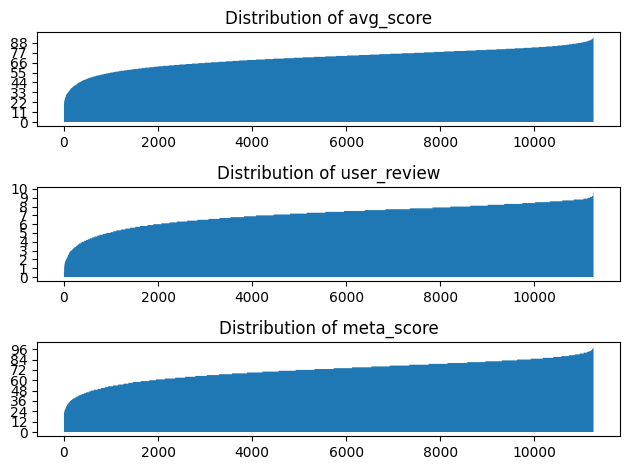

In [ ]:
def show_distribution(sample, cols):
  figure, axis = plt.subplots(len(cols), 1)

  # iterate over distributions to add
  for j, col in enumerate(cols):
    sample[col] = pd.to_numeric(sample[col])
    # sort values
    y = sample[col].sort_values()
    x = [i for i in range(len(y))]

    # scale axis
    axis[j].set_yticks([i for i in range(0, int(max(y))+2 , int(max(y))//8 )], minor=False)
    axis[j].set_title(f"Distribution of {col}")
    axis[j].fill_between(x, y)

  figure.tight_layout()
  plt.show()

sample = clean_data(create_sample(-1))
sample = engineer_features(sample)
show_distribution(sample, ["avg_score", "user_review", "meta_score"])

# 8: Correlation Analysis
Calculate the Pearson and Spearman correlations between the `user_rating`and `meta_rating`columns to understand how the values are correlated. The correlations are around 0.38-0.54, which imply some positive correlation.

In [ ]:
def calculate_corr(col1, col2, ctype="pearson"):
    sample[col1] = pd.to_numeric(sample[col1])
    sample[col2] = pd.to_numeric(sample[col2])
    return sample[col1].corr(sample[col2], ctype)

sample = clean_data(create_sample(-1))
print("------ *** ------\n")
print("Pearson Correlation: ",calculate_corr("user_review", "meta_score"))
print("Spearman Correlation: ",calculate_corr("user_review", "meta_score", "spearman"))
print("Kendall Correlation: ",calculate_corr("user_review", "meta_score", "kendall"))

18800
length of sample after removing duplicates:  12254
length of sample after removing empty reviews 11262
------ *** ------

Pearson Correlation:  0.5433354096142379
Spearman Correlation:  0.5196486731835019
Kendall Correlation:  0.3781658668028775


# 9: Trend Analysis
Plot the average user and critic rating per year, genre, platform.

18800
length of sample after removing duplicates:  12254
length of sample after removing empty reviews 11262


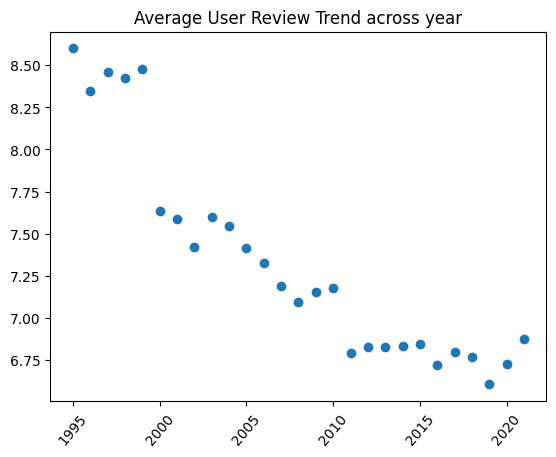

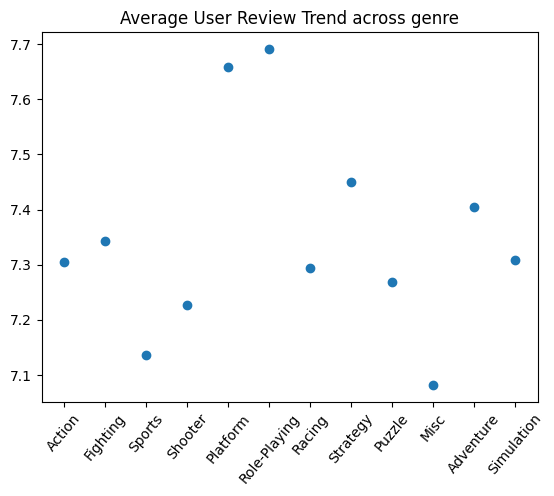

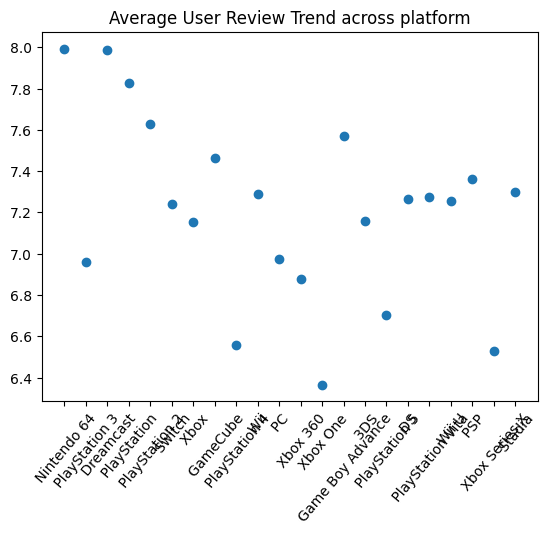

In [ ]:
def get_trend_averages(sample, trend, metric):
  data = {}
  avg = {}

  # creata a data map for plotting need
  for i, row in sample.iterrows():
    key = row[trend]
    row[metric] = pd.to_numeric(row[metric])
    tofind = row[metric]
    if key in data:
      data[key].append(tofind)
    else:
      data[key] = [tofind]

  for i, v in data.items():
    avg[i] = sum(v)/len(v)

  # start plotting setup
  x = [i for i in avg.keys() if i != None]
  y = [v for i, v in avg.items() if i != None]

  plt.scatter(x,y)
  plt.xticks(rotation=50)
  plt.title("Average User Review Trend across " + trend)
  plt.show()

sample = clean_data(create_sample(-1))
get_trend_averages(sample, "year", "user_review")
get_trend_averages(sample, "genre", "user_review")
get_trend_averages(sample, "platform", "user_review")

# 10: Frequecy Analysis
Create a word cloud of the most frequently occuring words accros summaries. This will let us if some words occur more often than the others in the specified field, like summary, or names.

18800
length of sample after removing duplicates:  12254
length of sample after removing empty reviews 11262
Word Cloud of Game Summary:


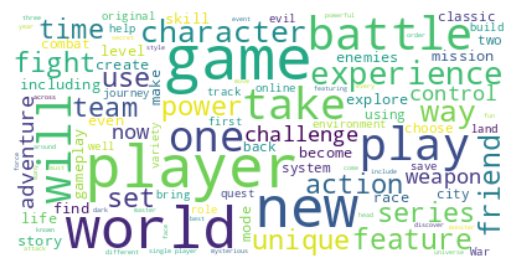



Word Cloud of Game Names:


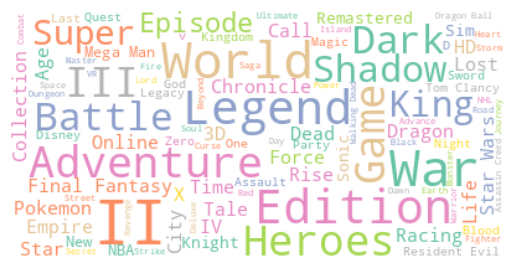

In [ ]:
def generate_word_cloud(sample, col, color):
  text = " ".join(summary for summary in sample[col])

  # call the library. adapted from documentation
  wordcloud = WordCloud(max_font_size=50, max_words=100, colormap=color, background_color="white").generate(text)

  plt.imshow(wordcloud,interpolation='bilinear')
  plt.axis("off")
  plt.show()

sample = clean_data(create_sample(-1))
print("Word Cloud of Game Summary:")
generate_word_cloud(sample, "summary", None)
print("\n")
print("Word Cloud of Game Names:")
generate_word_cloud(sample, "name", 'Set2')